In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from pymc3.gp.util import plot_gp_dist
#import matplotlib.cm as cmap

import numpy as np
import scipy as sp
import pandas as pd
import geopandas as gpd
np.random.seed(42)

import theano
import theano.tensor as tt
import pymc3 as pm

import pickle

import time

pm.__version__

from scipy import stats
from scipy.special import expit as logistic

import arviz as az

import math

/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/polichinel/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 88 from C header, got 96 from PyObject
  return f(*args, **kwds)


In [2]:
# Tror mpske kun jeg skal bruge point...

pkl_file = open('full_df.pkl', 'rb')

df = pickle.load(pkl_file)

pkl_file.close()

In [3]:
pkl_file = open('map.pkl', 'rb')

mp = pickle.load(pkl_file)

pkl_file.close()

In [4]:
mp

{'η': array([0.74898533]),
 'η_log__': array([-0.28903589]),
 'σ': array([0.72533913]),
 'σ_log__': array([-0.32111597]),
 'ℓ': array([1.16623133]),
 'ℓ_log__': array([0.15377746])}

In [5]:
y_north_limit = df[(df['year']==2017) & (df['best'] > 0)]['ycoord'].max()
y_south_limit = df[(df['year']==2017) & (df['best'] > 0)]['ycoord'].min()

#x_west_limit  = df[(df['year']==2017) & (df['best'] > 0)]['xcoord'].min()
x_west_limit  = -25
x_east_limit  = df[(df['year']==2017) & (df['best'] > 0)]['xcoord'].max()


df_sub = df[(df['year']==2017)&(df['ycoord'] > y_south_limit)&(df['ycoord'] < y_north_limit)&(df['xcoord']<x_east_limit)&(df['xcoord']>x_west_limit)]

# df_sub = df[df['year']==2017]

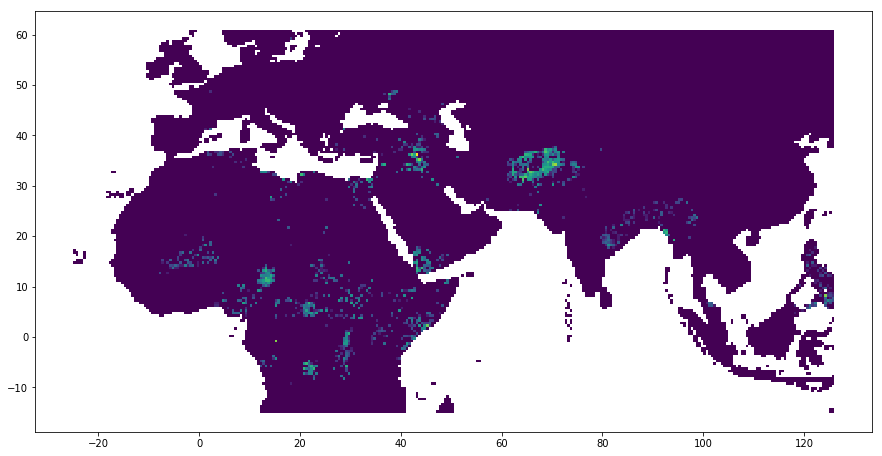

In [6]:
df_sub.plot(column = 'log_best', figsize=(15, 15))
plt.show()

In [7]:
X = np.array([df_sub['xcoord'], df_sub['ycoord']]).T

y = np.array(df_sub['log_best'])

In [8]:
sub1 = df_sub[df_sub['best']>0]

Xu = np.array([sub1['xcoord'], sub1['ycoord']]).T

In [9]:
Xu.shape

(1099, 2)

In [10]:
time0 = time.time()

with pm.Model() as model:
    
    # term trend
    ℓ = pm.Gamma("ℓ", alpha=2, beta=2, shape = 1)
    η = pm.HalfCauchy("η", beta=5, shape = 1)

    # noise model
    σ = pm.HalfCauchy("σ", beta=2, shape = 1)
        
    cov = η **2 * pm.gp.cov.ExpQuad(2, ℓ)
        
    gp = pm.gp.MarginalSparse(cov_func=cov, approx="DTC") # ved ikke om det gør en forskel til FICT
        
    y_ = gp.marginal_likelihood("y_", X=X, Xu = Xu, y=y, noise= σ)
        

In [11]:
time1 = time.time()

mu, var = gp.predict(X, point=mp, given = {'gp' : gp, 'X' : X, 'y' : y, 'noise' : σ }, diag=True)

In [12]:
time2 = time.time()

step1 = (time1 - time0)/60
step2 = (time2 - time1)/60
step12 = (time2 - time0)/60

print('step 1: {}min \nstep 2: {}min \n toltal: {}min'.format(step1, step2, step12))

step 1: 3.7326037844022113min 
step 2: 3.6858548482259113min 
 toltal: 7.4184586326281226min


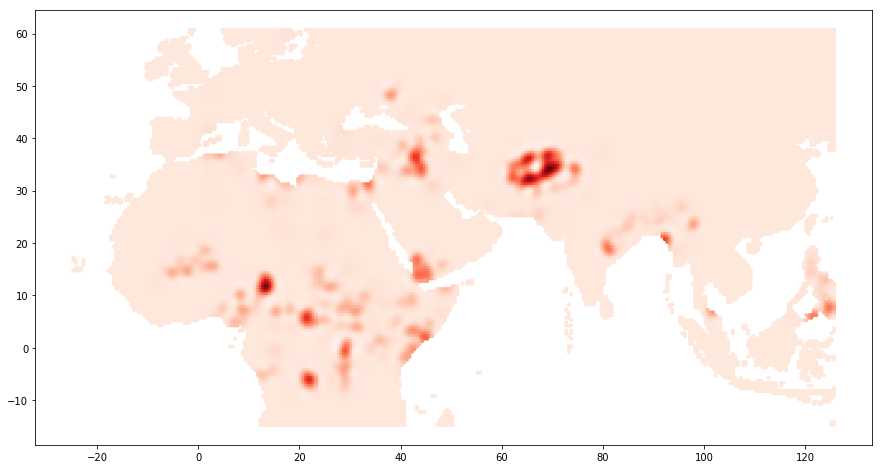

In [13]:
plt.figure(figsize=[15,8])
plt.scatter(X[:,0], X[:,1], s=35, c=mu, marker='.', cmap='Reds')
plt.show()

In [14]:
mp2 = mp.copy()

In [15]:
mp2['ℓ'] = mp['ℓ'] * 5 # should be cross validated agianst other years...
mp2['ℓ_log__'] = np.log(mp2['ℓ'] )

mp2

{'η': array([0.74898533]),
 'η_log__': array([-0.28903589]),
 'σ': array([0.72533913]),
 'σ_log__': array([-0.32111597]),
 'ℓ': array([5.83115663]),
 'ℓ_log__': array([1.76321537])}

In [16]:
mu, var = gp.predict(X, point=mp2, given = {'gp' : gp, 'X' : X, 'y' : y, 'noise' : σ }, diag=True)

<Figure size 1080x576 with 0 Axes>

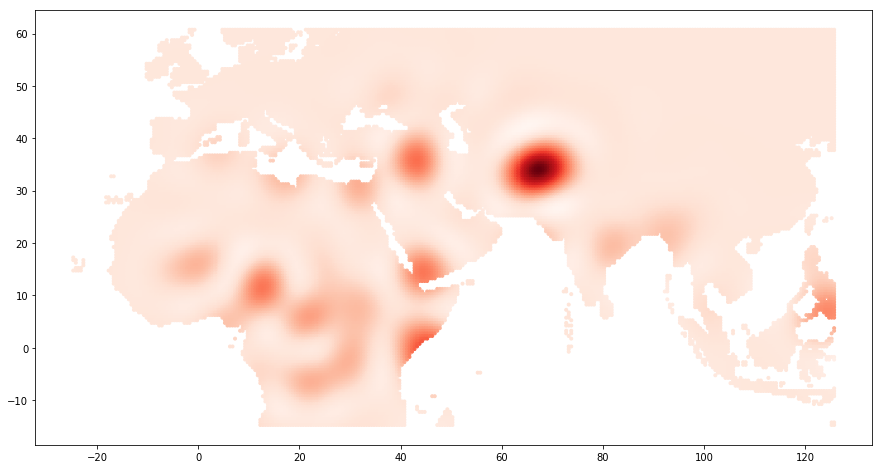

In [18]:
plt.figure(figsize=[15,8])
plt.scatter(X[:,0], X[:,1], s=35, c=mu, marker='.', cmap='Reds')
plt.show()

## 16.7 ish.. GB ram used.